In [1]:
#ALWAYS RUN FIRST!

#Import libraries and packages. Don't worry about the warning if running it on windows, so far not hit an issue. (yn)

import re
from pylab import *
import csv
import psycopg2
import spacy
spacy.load('en')
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
import pickle
import gensim
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

#Set the names of the files in which you want to save data.

question_data_name = 'question_data'

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#Extract the data from the CRM. Don't run if you have an up to date copy of the CRM.

try:
    
    #Opens connection to the CRM asks for the questions policy fellows asked and the date.
    #Output rows for row in rows row[0] - date, row[1] - question.
    
    print("Trying to access CRM CSaP database ...")
    
    conn = psycopg2.connect(SERVER_INFO)
    
    cur = conn.cursor()

    cur.execute("""SELECT
    fellow.start_date,
    question.question
    FROM people_policyfellowship as fellow 
    INNER JOIN 
    people_policyfellowshipquestion as question 
    ON
    fellow.id = question.policy_fellowship_id
    ;
    """)
    rows = cur.fetchall()
    
    #Saves data to the file called above.
    
    with open(os.getcwd() + '\data\\' + question_data_name + '.csv','w+',newline ='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        for row in rows:
            wr.writerow([str(row[0]), row[1].encode('utf-8')])
    
    print("... data downloaded and saved to disk.")
    
except:
    
    #If server isn't online this collects data from the save file.
    
    print("... can't access server, is the tunnel set up? Can continue on previously saved data.")

Trying to access CRM CSaP database ...
... data downloaded and saved to disk.


In [4]:
#Functions for cleaning the text and getting it ready to be procced.

#Gets rid of HTML tags and end of line markers.
#Input: String of text from CRM or internet.
#Output: Cleaned up string of text without HTML tags or end of line markers.

def clean_text(text):
    
    #Removes HTML tags.
    
    clean = re.compile('<.*?>')
    temp_text = re.sub(clean, '', text)
    
    #Removes rouge utf-8 code.
    
    clean = re.compile('\\\\x\w\w')
    temp_text = re.sub(clean, '', temp_text)
    
    clean = re.compile('\\\\x\w')
    temp_text = re.sub(clean, '', temp_text)
    
    #Removes end of line indicators and other junk.
    
    tags = ['\\r','\\n','/','\\t','\\']
    
    for tag in tags:
        temp_text = temp_text.replace(tag,'')
    
    return temp_text

#Tokenizes text, seperates it into a string of words and grammar.
#Input: A string of text.
#Output: A list of words and grammar in order all in lower case.

parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

#Lemmatiser, this finds the root word (i.e. depluralises).
#Input: a token, i.e. a single word or grammar.
#Output: a lemma which is the base of the word and association 

def get_lemma(word):
    return WordNetLemmatizer().lemmatize(word)

#Checks if two words are synonyms or antonyms.
#Input: Takes two strings word_1 and word_2, they should be prepared words.
#Output: Returns 1 if they are synonyms, -1 if they are antonyms or 0 otherwise.

def is_synonym_antonym(word_1,word_2):
    word_1_synonyms = set([word for synset in wn.synsets(word_1) for word in synset.lemma_names()])
    word_2_synonyms = set([word for synset in wn.synsets(word_2) for word in synset.lemma_names()])
    word_1_antonyms = set([ant.name() for synset in wn.synsets(word_1) for syn in synset.lemmas() for ant in syn.antonyms()])
    word_2_antonyms = set([ant.name() for synset in wn.synsets(word_2) for syn in synset.lemmas() for ant in syn.antonyms()])

    l.antonyms()
    if word_1_synonyms & word_2_synonyms or word_1_antonyms & word_2_antonyms:
        return 1

    if word_1_synonyms & word_2_antonyms or word_2_synonyms & word_1_antonyms:
        return -1
    
    return 0
    
#Prepares text for the analysis, tokenizes texts, gets rid of words length less than 4 and filters out non-useful words then
#Lemmatisers the text.
#Input: A string of text you want to analysis.
#Output: A list of Lemmas of the meaningful words.

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [tok[0] for tok in nltk.pos_tag(tokens) if tok[1][0] == 'N']
    tokens = [token for token in tokens if len(token) > 4]
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [5]:
#This uploads the data into the program from the file, cleaning the data whilst it does it.

print("Trying to load up data ...")

questions = []

try:
    with open(os.getcwd() + '\data\\' + question_data_name + '.csv', 'r') as csvfile:
        dump = list(csv.reader(csvfile))
        for row in dump:
            questions.append([datetime.strptime(row[0],'%Y-%m-%d'),prepare_text_for_lda(clean_text(row[1][2:-1]))])
    
    print("... data successfully uploaded.")
    
except:
    
    print(".. no back up data, please connect to server.")

Trying to load up data ...
... data successfully uploaded.


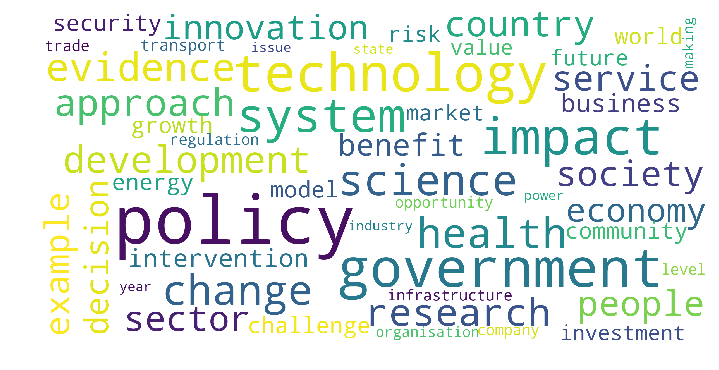

In [6]:
#Gets the questions that lie between two dates.
#Input: Takes two timedate objects start_date and end_date and the list of questions with dates.
#Output: List of dates and questions that where asked on or after start_date and on or before end_date.

def get_between(start_date,end_date,question_list):
    amended_list = []
    for entry in question_list:
        if entry[0] >= start_date and entry[0] <= end_date:
            amended_list.append(entry)
    return amended_list

#Turns list of questions into frequency distrubution.
#Input: List of questions.
#Output: A dictionary with words as names and numbers associated to them as frequency.

def prepare_for_word_cloud(question_list):
    frequency_list = {}
    for entry in question_list:
        for word in entry[1]:
            try:
                frequency_list[word] += 1
            except:
                frequency_list[word] = 1
    return frequency_list

#Makes and saves a word cloud of the given frequency list.
#Input: A dictionary of words with frequency and a name to save the file.
#Output: empty but saves a plot of the word cloud with name save_file given the frequency_list.

def make_word_cloud(frequency_list, save_file):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        max_font_size=80,
        min_font_size=8,
        scale=3,
        random_state=0
    ).generate_from_frequencies(frequency_list)
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig(os.getcwd() + '\output\\' +  save_file + '.png')

#Saves 4 word clouds spanning of the 2 year intervals 2011/2, 2013/4 2015/6 and 2017/8.
    
for run in [['2011-01-01', '2012-12-31', 'Cloud_11-2'],['2013-01-01', '2014-12-31', 'Cloud_13-4'],['2015-01-01', '2016-12-31', 'Cloud_15-6'],['2017-01-01', '2018-12-31', 'Cloud_17-8']]:
    make_word_cloud(prepare_for_word_cloud(get_between(datetime.strptime(run[0],'%Y-%m-%d'),datetime.strptime(run[1],'%Y-%m-%d'),questions)),run[2])
